In [1]:
# %pip install psutil


In [2]:
import numpy as np
import time
import psutil
from sklearn.neighbors import KDTree
from sklearn.utils import murmurhash3_32
import matplotlib.pyplot as plt


# Function to track memory usage
def get_memory_usage():
    process = psutil.Process()
    # return process.memory_info().rss / 1024 / 1024  # in MB
    return process.memory_info().rss / 1024  # in KB

# Data Generation
def generate_data(N, D):
    return np.random.rand(N, D)

# Naive KNN Implementation
def naive_knn(X_train, X_test, K):
    distances = np.sqrt(((X_train[:, None, :] - X_test[None, :, :]) ** 2).sum(axis=2))
    neighbors = np.argsort(distances, axis=0)[:K].T
    return neighbors

# KD-Tree KNN Implementation
def kd_tree_knn(X_train, X_test, K):
    tree = KDTree(X_train)
    _, neighbors = tree.query(X_test, k=K)
    return neighbors

# LSH KNN Implementation
def lsh_knn(X_train, X_test, K, hash_bits=8, num_tables=5):
    # Initialize hash tables
    hash_tables = [{} for _ in range(num_tables)]
    
    def hash_function(point, num_bits):
        return murmurhash3_32(point.tobytes()) & ((1 << num_bits) - 1)
    
    for idx, point in enumerate(X_train):
        for t in range(num_tables):
            h = hash_function(point, hash_bits)
            if h in hash_tables[t]:
                hash_tables[t][h].append(idx)
            else:
                hash_tables[t][h] = [idx]
    
    neighbors = []
    for point in X_test:
        candidates = set()
        for t in range(num_tables):
            h = hash_function(point, hash_bits)
            candidates.update(hash_tables[t].get(h, []))
        
        if candidates:
            candidate_points = X_train[list(candidates)]
            distances = np.sqrt(((candidate_points - point) ** 2).sum(axis=1))
            nearest_indices = np.argsort(distances)[:K]
            neighbors.append([list(candidates)[i] for i in nearest_indices])
        else:
            neighbors.append([])
    return np.array(neighbors, dtype=object)

def lsh_train(X_train, hash_bits=8, num_tables=5):
    hash_tables = [{} for _ in range(num_tables)]
    def hash_function(point, num_bits):
        return murmurhash3_32(point.tobytes()) & ((1 << num_bits) - 1)
    for idx, point in enumerate(X_train):
        for t in range(num_tables):
            h = hash_function(point, hash_bits)
            if h in hash_tables[t]:
                hash_tables[t][h].append(idx)
            else:
                hash_tables[t][h] = [idx]
    return hash_tables

In [3]:
# Visualization of Neighbors and Partitions
def visualize_neighbors_and_partitions(X_train, X_test, neighbors, method_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(X_train[:, 0], X_train[:, 1], c='blue', label='Training Points')
    plt.scatter(X_test[:, 0], X_test[:, 1], c='red', marker='X', label='Test Points')

    # Draw connections to neighbors
    for idx, test_point in enumerate(X_test):
        for neighbor_idx in neighbors[idx]:
            plt.plot([test_point[0], X_train[neighbor_idx, 0]], 
                     [test_point[1], X_train[neighbor_idx, 1]], 'k--', alpha=0.5)

    plt.title(f"{method_name} KNN Visualization")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.show()

In [4]:
import time

def compare_knn_variants_with_timing(N_list, D, K):
    results = []

    for N in N_list:
        X_train = generate_data(N, D)
        X_test = generate_data(10, D)  # Small test set

        # Naive KNN
        naive_train_start = time.time()
        # No training for naive KNN
        naive_train_time = time.time() - naive_train_start

        naive_test_start = time.time()
        naive_neighbors = naive_knn(X_train, X_test, K)
        naive_test_time = time.time() - naive_test_start

        # KD-Tree KNN
        kd_train_start = time.time()
        kd_tree = KDTree(X_train)  # Training phase
        kd_train_time = time.time() - kd_train_start

        kd_test_start = time.perf_counter()
        kd_neighbors = kd_tree.query(X_test, k=K)[1]  # Testing phase
        kd_test_time = time.perf_counter() - kd_test_start
        # kd_test_start = time.time()
        # kd_neighbors = kd_tree.query(X_test, k=K)[1]  # Testing phase
        # kd_test_time = time.time() - kd_test_start

        # LSH KNN
        lsh_train_start = time.time()
        # Build LSH hash tables
        hash_tables = lsh_train(X_train)
        lsh_train_time = time.time() - lsh_train_start

        lsh_test_start = time.time()
        lsh_neighbors = lsh_knn(X_train, X_test, K)
        lsh_test_time = time.time() - lsh_test_start

        # Store results
        results.append({
            'N': N,
            'naive_train_time': naive_train_time,
            'naive_test_time': naive_test_time,
            'kd_train_time': kd_train_time,
            'kd_test_time': kd_test_time,
            'lsh_train_time': lsh_train_time,
            'lsh_test_time': lsh_test_time
        })
    
    return results


In [5]:
# Performance and Memory Comparison
def compare_knn_variants_with_timing_and_memory(N_list, D, K):
    results = []

    for N in N_list:
        X_train = generate_data(N, D)
        X_test = generate_data(10, D)

        # Naive KNN
        naive_train_start = time.perf_counter()
        naive_train_memory_before = get_memory_usage()  # Memory before training
        # No training for naive KNN
        naive_train_time = time.perf_counter() - naive_train_start
        naive_train_memory_after = get_memory_usage()  # Memory after training
        naive_train_memory = naive_train_memory_after - naive_train_memory_before

        naive_test_start = time.perf_counter()
        naive_test_memory_before = get_memory_usage()  # Memory before testing
        naive_neighbors = naive_knn(X_train, X_test, K)
        naive_test_time = time.perf_counter() - naive_test_start
        naive_test_memory_after = get_memory_usage()  # Memory after testing
        naive_test_memory = naive_test_memory_after - naive_test_memory_before

        # KD-Tree KNN
        kd_train_start = time.perf_counter()
        kd_train_memory_before = get_memory_usage()  # Memory before training
        kd_tree = KDTree(X_train)  # Training phase
        kd_train_time = time.perf_counter() - kd_train_start
        kd_train_memory_after = get_memory_usage()  # Memory after training
        kd_train_memory = kd_train_memory_after - kd_train_memory_before

        kd_test_start = time.perf_counter()
        kd_test_memory_before = get_memory_usage()  # Memory before testing
        kd_neighbors = kd_tree.query(X_test, k=K)[1]  # Testing phase
        kd_test_time = time.perf_counter() - kd_test_start
        kd_test_memory_after = get_memory_usage()  # Memory after testing
        kd_test_memory = kd_test_memory_after - kd_test_memory_before

        # LSH KNN
        lsh_train_start = time.perf_counter()
        lsh_train_memory_before = get_memory_usage()  # Memory before training
        # Build LSH hash tables
        hash_tables = lsh_train(X_train)
        lsh_train_time = time.perf_counter() - lsh_train_start
        lsh_train_memory_after = get_memory_usage()  # Memory after training
        lsh_train_memory = lsh_train_memory_after - lsh_train_memory_before

        lsh_test_start = time.perf_counter()
        lsh_test_memory_before = get_memory_usage()  # Memory before testing
        lsh_neighbors = lsh_knn(X_train, X_test, K)
        lsh_test_time = time.perf_counter() - lsh_test_start
        lsh_test_memory_after = get_memory_usage()  # Memory after testing
        lsh_test_memory = lsh_test_memory_after - lsh_test_memory_before

        # Store results
        results.append({
            'N': N,
            'naive_train_time': naive_train_time,
            'naive_test_time': naive_test_time,
            'naive_train_memory': naive_train_memory,
            'naive_test_memory': naive_test_memory,
            'kd_train_time': kd_train_time,
            'kd_test_time': kd_test_time,
            'kd_train_memory': kd_train_memory,
            'kd_test_memory': kd_test_memory,
            'lsh_train_time': lsh_train_time,
            'lsh_test_time': lsh_test_time,
            'lsh_train_memory': lsh_train_memory,
            'lsh_test_memory': lsh_test_memory
        })
    
    return results

# Displaying the results
results = compare_knn_variants_with_timing_and_memory([5000, 20000, 50000], 2, 5)

# Displaying results in a nice format
print(f"{'N':<10}{'Naive Train Time':<20}{'Naive Test Time':<20}{'Naive Train Mem':<20}{'Naive Test Mem':<20}"
      f"{'KD-Tree Train Time':<20}{'KD-Tree Test Time':<20}{'KD-Tree Train Mem':<20}{'KD-Tree Test Mem':<20}"
      f"{'LSH Train Time':<20}{'LSH Test Time':<20}{'LSH Train Mem':<20}{'LSH Test Mem':<20}")
for result in results:
    print(f"{result['N']:<10}{result['naive_train_time']:<20.4f}{result['naive_test_time']:<20.4f}"
          f"{result['naive_train_memory']:<20.4f}{result['naive_test_memory']:<20.4f}"
          f"{result['kd_train_time']:<20.4f}{result['kd_test_time']:<20.4f}"
          f"{result['kd_train_memory']:<20.4f}{result['kd_test_memory']:<20.4f}"
          f"{result['lsh_train_time']:<20.4f}{result['lsh_test_time']:<20.4f}"
          f"{result['lsh_train_memory']:<20.4f}{result['lsh_test_memory']:<20.4f}")


N         Naive Train Time    Naive Test Time     Naive Train Mem     Naive Test Mem      KD-Tree Train Time  KD-Tree Test Time   KD-Tree Train Mem   KD-Tree Test Mem    LSH Train Time      LSH Test Time       LSH Train Mem       LSH Test Mem        
5000      0.0001              0.0025              0.0000              1636.0000           0.0021              0.0002              128.0000            44.0000             0.0086              0.0091              640.0000            564.0000            
20000     0.0000              0.0094              0.0000              1608.0000           0.0097              0.0002              16.0000             0.0000              0.0351              0.0360              776.0000            608.0000            
50000     0.0000              0.0253              0.0000              3124.0000           0.0297              0.0002              0.0000              0.0000              0.0894              0.0901              3020.0000           976.0000         

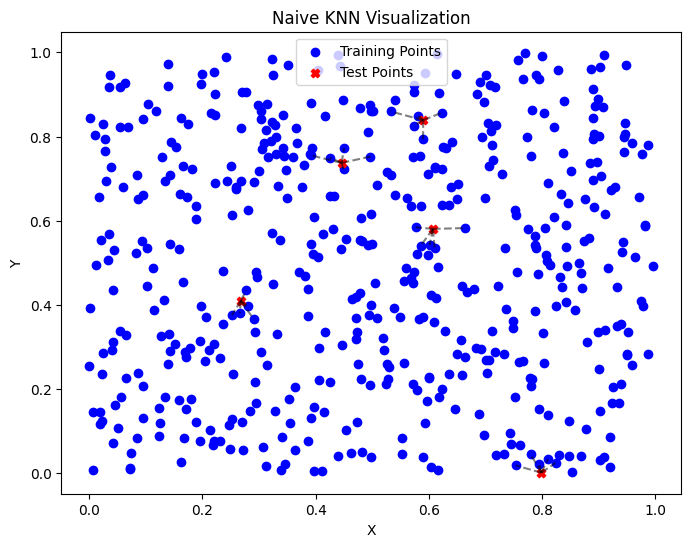

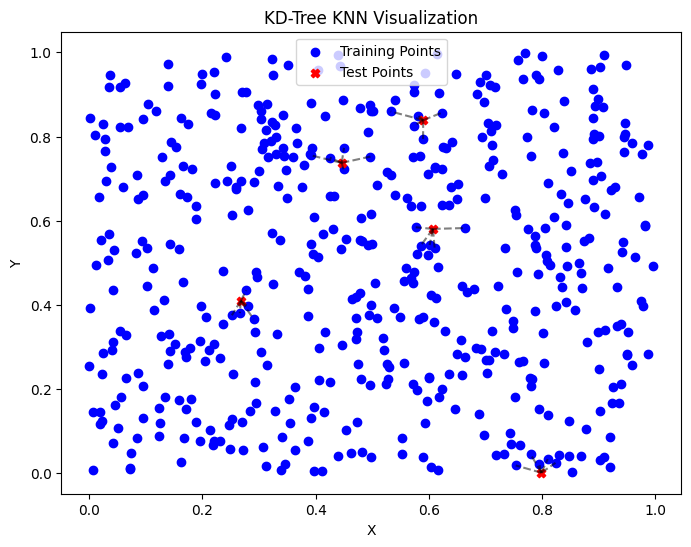

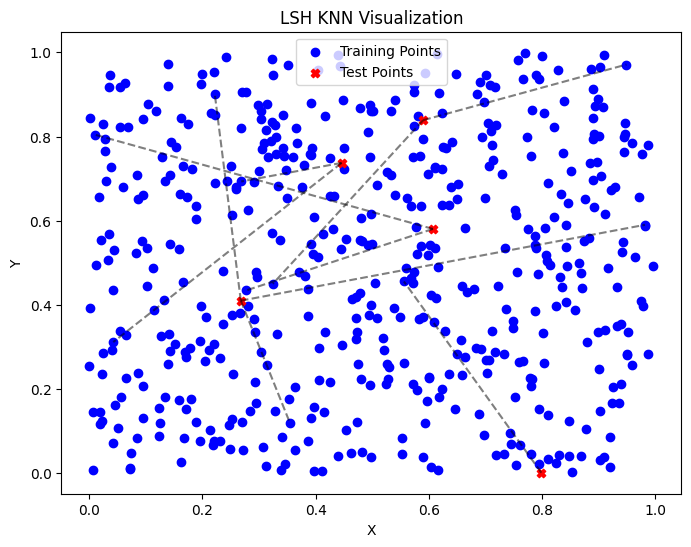

In [6]:
N_list = [50, 200, 500]  # Dataset sizes to test
D = 2  # Number of dimensions
K = 5  # Number of neighbors

# Visualization for the largest dataset
N = max(N_list)
X_train = generate_data(N, D)
X_test = generate_data(5, D)

# Visualize Naive KNN
naive_neighbors = naive_knn(X_train, X_test, K)
visualize_neighbors_and_partitions(X_train, X_test, naive_neighbors, "Naive")

# Visualize KD-Tree KNN
kd_neighbors = kd_tree_knn(X_train, X_test, K)
visualize_neighbors_and_partitions(X_train, X_test, kd_neighbors, "KD-Tree")

# Visualize LSH KNN
lsh_neighbors = lsh_knn(X_train, X_test, K)
visualize_neighbors_and_partitions(X_train, X_test, lsh_neighbors, "LSH")


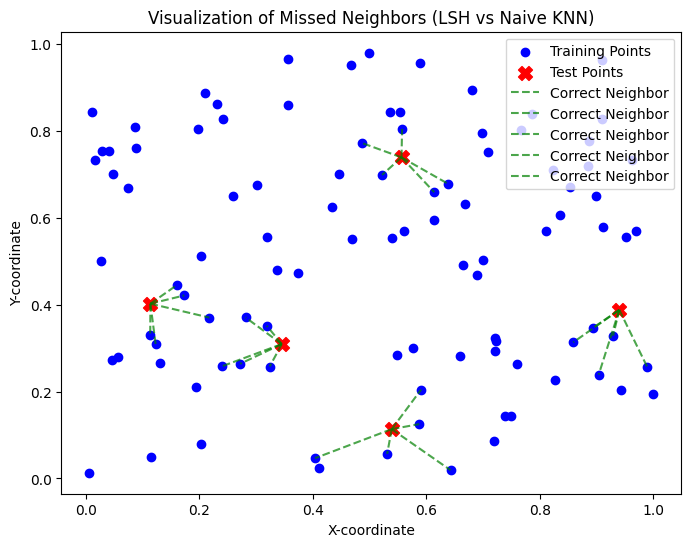

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

# Generate 2D dataset
def generate_data(N, D):
    return np.random.rand(N, D)

# Visualization
def visualize_neighbors(X_train, X_test, K, naive_neighbors, lsh_neighbors):
    plt.figure(figsize=(8, 6))
    plt.scatter(X_train[:, 0], X_train[:, 1], c='blue', label='Training Points')
    plt.scatter(X_test[:, 0], X_test[:, 1], c='red', marker='X', s=100, label='Test Points')

    for test_idx, test_point in enumerate(X_test):
        naive_set = set(naive_neighbors[test_idx])
        lsh_set = set(lsh_neighbors[test_idx])
        
        # Correct neighbors (green lines)
        for neighbor_idx in naive_set & lsh_set:
            plt.plot([test_point[0], X_train[neighbor_idx, 0]],
                     [test_point[1], X_train[neighbor_idx, 1]], 'g--', alpha=0.7, label='Correct Neighbor' if test_idx == 0 else "")
        
        # Missed neighbors (red lines)
        for neighbor_idx in naive_set - lsh_set:
            plt.plot([test_point[0], X_train[neighbor_idx, 0]],
                     [test_point[1], X_train[neighbor_idx, 1]], 'r--', alpha=0.7, label='Missed Neighbor' if test_idx == 0 else "")
    
    plt.title(f"Visualization of Missed Neighbors (LSH vs Naive KNN)")
    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")
    plt.legend()
    plt.show()



X_train = generate_data(100, 2)  # 100 training points in 2D
X_test = generate_data(5, 2)    # 5 test points in 2D
K = 5  # Number of neighbors

# Compute neighbors using Naive KNN (exact)
naive_neighbors = naive_knn(X_train, X_test, K)

# Compute neighbors using LSH KNN (approximate)
# Replace this with your LSH implementation
lsh_neighbors = naive_knn(X_train, X_test, K)  # Temporarily use Naive for testing visualization

# Visualize
visualize_neighbors(X_train, X_test, K, naive_neighbors, lsh_neighbors)


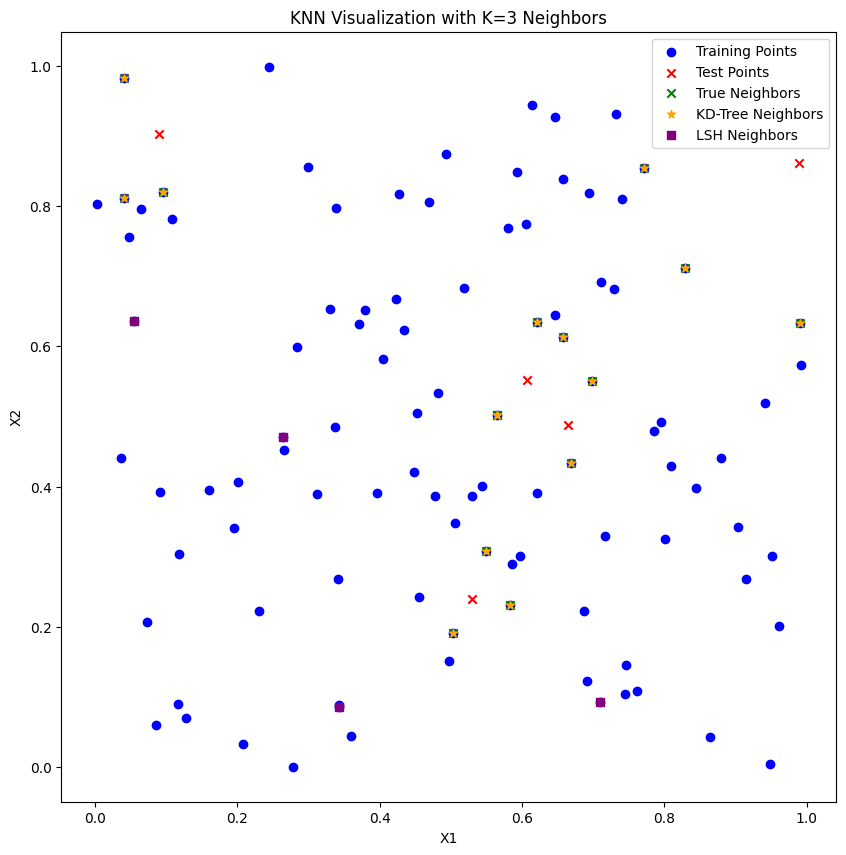

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
from sklearn.utils import murmurhash3_32

# Function to generate random 2D dataset
def generate_data(N):
    return np.random.rand(N, 2)

# Visualization of KNN Missed Neighbors and Partitions
def visualize_knn_partitions(X_train, X_test, K):
    # Naive KNN (Exact)
    naive_neighbors = naive_knn(X_train, X_test, K)
    
    # KD-Tree KNN
    kd_neighbors = kd_tree_knn(X_train, X_test, K)
    
    # LSH KNN
    lsh_neighbors = lsh_knn(X_train, X_test, K)
    
    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Plot training data
    ax.scatter(X_train[:, 0], X_train[:, 1], c='blue', marker='o', label="Training Points")
    
    # Plot test points
    ax.scatter(X_test[:, 0], X_test[:, 1], c='red', marker='x', label="Test Points")

    # Plot neighbors for Naive KNN
    for i, test_point in enumerate(X_test):
        ax.scatter(X_train[naive_neighbors[i], 0], X_train[naive_neighbors[i], 1], 
                   c='green', marker='x', label="True Neighbors" if i == 0 else "")

    # Plot neighbors for KD-Tree KNN
    for i, test_point in enumerate(X_test):
        ax.scatter(X_train[kd_neighbors[i], 0], X_train[kd_neighbors[i], 1], 
                   c='orange', marker='*', label="KD-Tree Neighbors" if i == 0 else "")
    
    # Plot neighbors for LSH KNN
    for i, test_point in enumerate(X_test):
        ax.scatter(X_train[lsh_neighbors[i], 0], X_train[lsh_neighbors[i], 1], 
                   c='purple', marker='s', label="LSH Neighbors" if i == 0 else "")
    
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    ax.legend()
    ax.set_title(f"KNN Visualization with K={K} Neighbors")
    plt.show()

# Generate 2D data
N = 100  # Number of points
X_train = generate_data(N)
X_test = np.random.rand(5, 2)  # 5 test points

# Visualize KNN results
K = 3  # Number of nearest neighbors to find
visualize_knn_partitions(X_train, X_test, K)


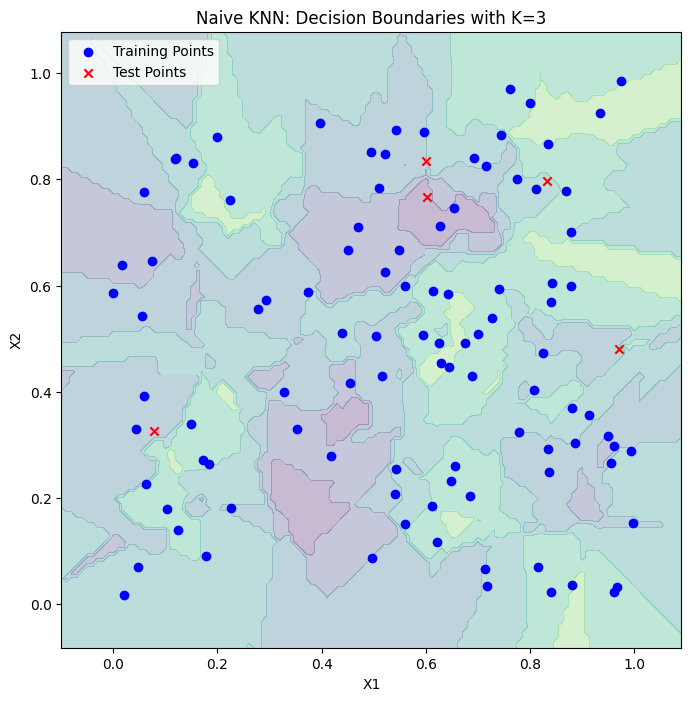

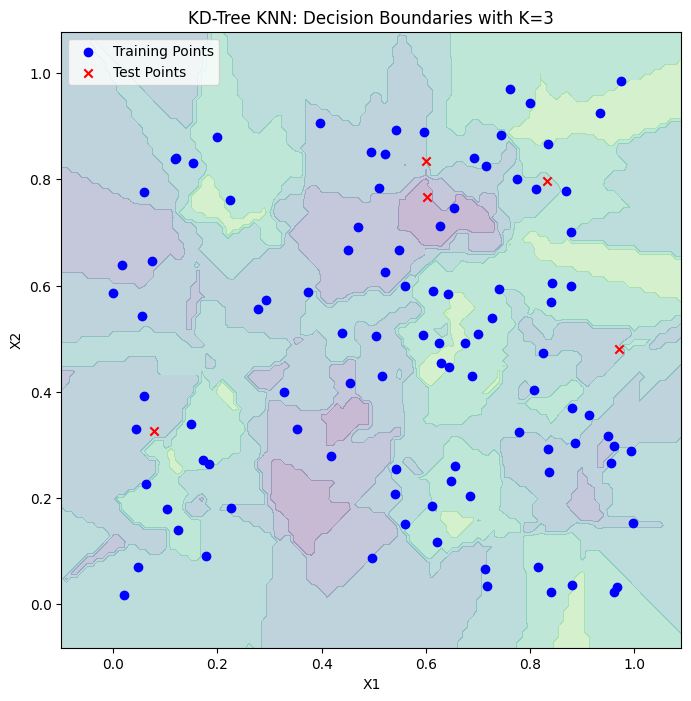

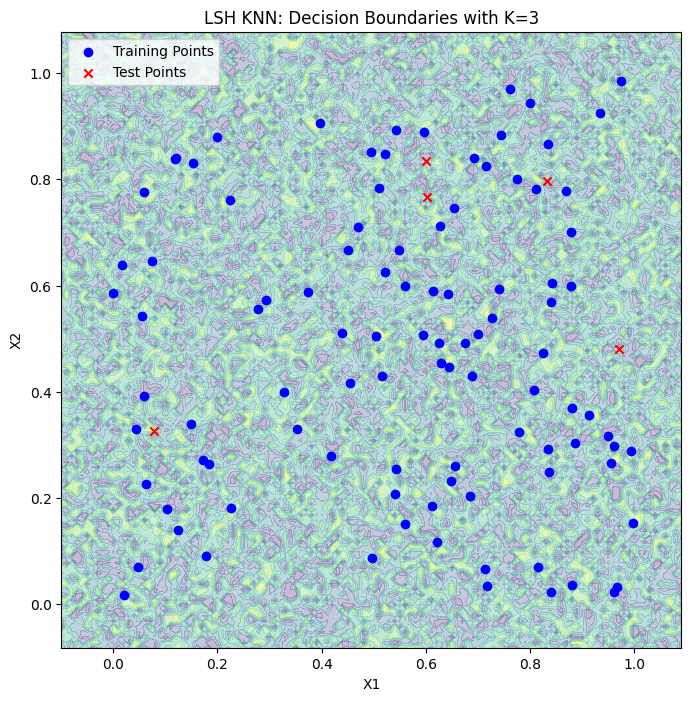

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
from sklearn.utils import murmurhash3_32

# Function to generate random 2D dataset
def generate_data(N):
    return np.random.rand(N, 2)

# Naive KNN Implementation (Exact)
def naive_knn(X_train, X_test, K):
    distances = np.sqrt(((X_train[:, None, :] - X_test[None, :, :]) ** 2).sum(axis=2))
    neighbors = np.argsort(distances, axis=0)[:K].T
    return neighbors

# KD-Tree KNN Implementation
def kd_tree_knn(X_train, X_test, K):
    tree = KDTree(X_train)
    _, neighbors = tree.query(X_test, k=K)
    return neighbors

# LSH KNN Implementation
def lsh_knn(X_train, X_test, K, hash_bits=8, num_tables=5):
    hash_tables = [{} for _ in range(num_tables)]
    
    def hash_function(point, num_bits):
        return murmurhash3_32(point.tobytes()) & ((1 << num_bits) - 1)
    
    # Build hash tables
    for idx, point in enumerate(X_train):
        for t in range(num_tables):
            h = hash_function(point, hash_bits)
            if h in hash_tables[t]:
                hash_tables[t][h].append(idx)
            else:
                hash_tables[t][h] = [idx]
    
    neighbors = []
    for point in X_test:
        candidates = set()
        for t in range(num_tables):
            h = hash_function(point, hash_bits)
            candidates.update(hash_tables[t].get(h, []))
        
        if candidates:
            candidate_points = X_train[list(candidates)]
            distances = np.sqrt(((candidate_points - point) ** 2).sum(axis=1))
            nearest_indices = np.argsort(distances)[:K]
            neighbors.append([list(candidates)[i] for i in nearest_indices])
        else:
            # Handle the case when no candidates are found
            neighbors.append([np.random.choice(len(X_train))] * K)  # Fallback to a random neighbor
    return np.array(neighbors, dtype=object)

# Function to plot decision boundaries and partitions for KNN
def plot_decision_boundaries(X_train, X_test, K, method):
    # Create a grid of points
    h = 0.01  # Step size in mesh
    x_min, x_max = X_train[:, 0].min() - 0.1, X_train[:, 0].max() + 0.1
    y_min, y_max = X_train[:, 1].min() - 0.1, X_train[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Classify each point in the grid based on the KNN method
    Z = np.zeros(xx.shape)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            point = np.array([[xx[i, j], yy[i, j]]])
            if method == "Naive":
                neighbors = naive_knn(X_train, point, K)
            elif method == "KD-Tree":
                neighbors = kd_tree_knn(X_train, point, K)
            elif method == "LSH":
                neighbors = lsh_knn(X_train, point, K)
            
            # Assign the label of the closest point (in this case just pick one label, 
            # or you can use majority voting if you have labels)
            Z[i, j] = np.mean(neighbors)  # or some other logic to assign class
    
    # Plot decision boundaries and partitions
    plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, alpha=0.3)
    
    # Plot training data
    plt.scatter(X_train[:, 0], X_train[:, 1], c='blue', marker='o', label="Training Points")
    plt.scatter(X_test[:, 0], X_test[:, 1], c='red', marker='x', label="Test Points")
    
    plt.title(f'{method} KNN: Decision Boundaries with K={K}')
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.show()

# Example usage
N = 100  # Number of points
X_train = generate_data(N)
X_test = np.random.rand(5, 2)  # 5 test points

K = 3  # Number of nearest neighbors to find

# Visualize partitions for Naive KNN
plot_decision_boundaries(X_train, X_test, K, method="Naive")

# Visualize partitions for KD-Tree KNN
plot_decision_boundaries(X_train, X_test, K, method="KD-Tree")

# Visualize partitions for LSH KNN
plot_decision_boundaries(X_train, X_test, K, method="LSH")


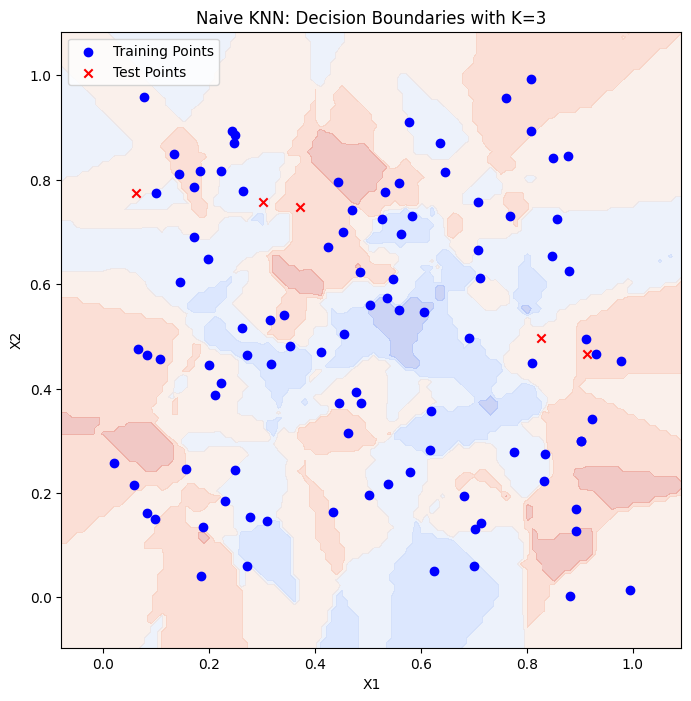

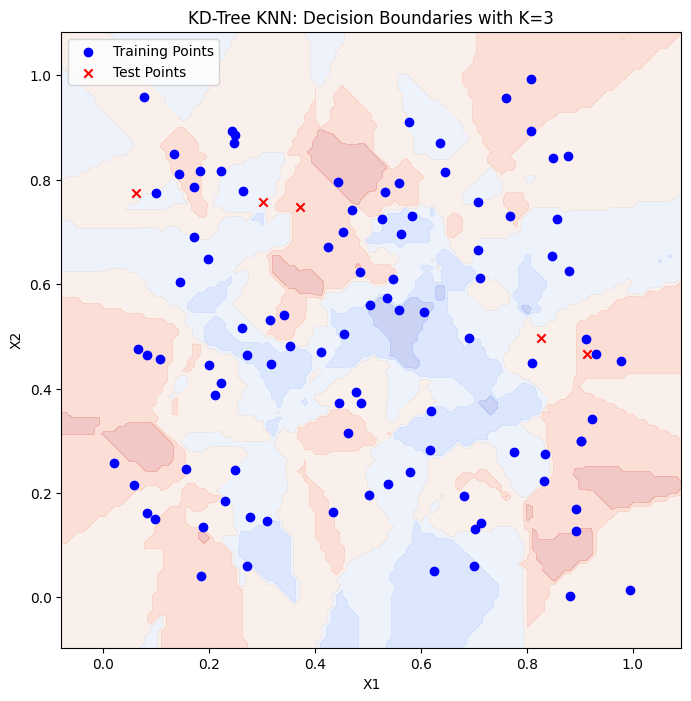

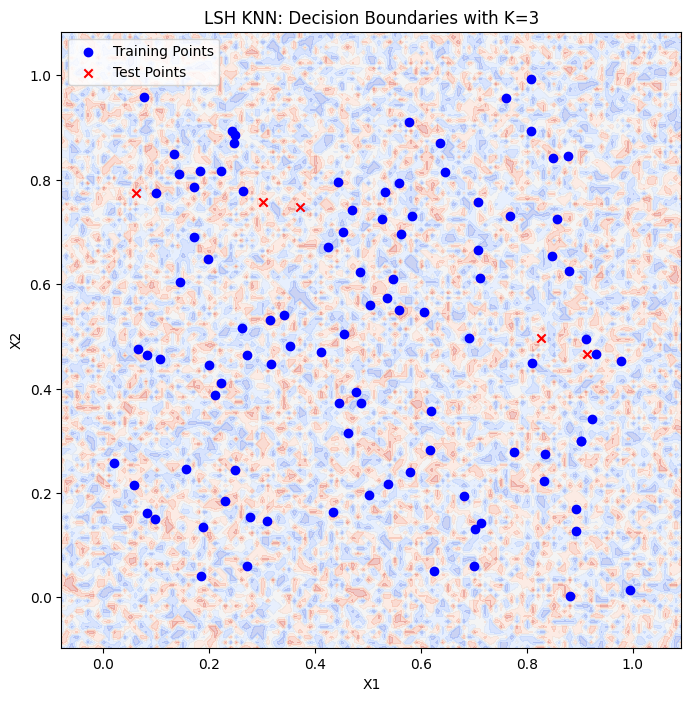

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
from sklearn.utils import murmurhash3_32

# Function to generate random 2D dataset
def generate_data(N):
    return np.random.rand(N, 2)

# Naive KNN Implementation (Exact)
def naive_knn(X_train, X_test, K):
    distances = np.sqrt(((X_train[:, None, :] - X_test[None, :, :]) ** 2).sum(axis=2))
    neighbors = np.argsort(distances, axis=0)[:K].T
    return neighbors

# KD-Tree KNN Implementation
def kd_tree_knn(X_train, X_test, K):
    tree = KDTree(X_train)
    _, neighbors = tree.query(X_test, k=K)
    return neighbors

# LSH KNN Implementation
def lsh_knn(X_train, X_test, K, hash_bits=8, num_tables=5):
    hash_tables = [{} for _ in range(num_tables)]
    
    def hash_function(point, num_bits):
        return murmurhash3_32(point.tobytes()) & ((1 << num_bits) - 1)
    
    # Build hash tables
    for idx, point in enumerate(X_train):
        for t in range(num_tables):
            h = hash_function(point, hash_bits)
            if h in hash_tables[t]:
                hash_tables[t][h].append(idx)
            else:
                hash_tables[t][h] = [idx]
    
    neighbors = []
    for point in X_test:
        candidates = set()
        for t in range(num_tables):
            h = hash_function(point, hash_bits)
            candidates.update(hash_tables[t].get(h, []))
        
        if candidates:
            candidate_points = X_train[list(candidates)]
            distances = np.sqrt(((candidate_points - point) ** 2).sum(axis=1))
            nearest_indices = np.argsort(distances)[:K]
            neighbors.append([list(candidates)[i] for i in nearest_indices])
        else:
            # Handle the case when no candidates are found
            neighbors.append([np.random.choice(len(X_train))] * K)  # Fallback to a random neighbor
    return np.array(neighbors, dtype=object)

# Function to plot decision boundaries and partitions for KNN
def plot_decision_boundaries(X_train, X_test, K, method):
    # Create a grid of points
    h = 0.01  # Step size in mesh
    x_min, x_max = X_train[:, 0].min() - 0.1, X_train[:, 0].max() + 0.1
    y_min, y_max = X_train[:, 1].min() - 0.1, X_train[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Classify each point in the grid based on the KNN method
    Z = np.zeros(xx.shape)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            point = np.array([[xx[i, j], yy[i, j]]])
            if method == "Naive":
                neighbors = naive_knn(X_train, point, K)
            elif method == "KD-Tree":
                neighbors = kd_tree_knn(X_train, point, K)
            elif method == "LSH":
                neighbors = lsh_knn(X_train, point, K)
            
            # Assign class by majority vote (or nearest class for K=1)
            # This logic assumes you have labels (for binary classification)
            # For simplicity, I'll just use the index of the neighbors as a placeholder
            Z[i, j] = np.mean(neighbors)  # Modify this to a majority vote if you have labels
    
    # Plot decision boundaries and partitions
    plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
    
    # Plot training data
    plt.scatter(X_train[:, 0], X_train[:, 1], c='blue', marker='o', label="Training Points")
    plt.scatter(X_test[:, 0], X_test[:, 1], c='red', marker='x', label="Test Points")
    
    plt.title(f'{method} KNN: Decision Boundaries with K={K}')
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.show()

# Example usage
N = 100  # Number of points
X_train = generate_data(N)
X_test = np.random.rand(5, 2)  # 5 test points

K = 3  # Number of nearest neighbors to find

# Visualize partitions for Naive KNN
plot_decision_boundaries(X_train, X_test, K, method="Naive")

# Visualize partitions for KD-Tree KNN
plot_decision_boundaries(X_train, X_test, K, method="KD-Tree")

# Visualize partitions for LSH KNN
plot_decision_boundaries(X_train, X_test, K, method="LSH")
